Route for vehicle 0:
 0 ->  12 ->  9 ->  3 ->  7 ->  11 ->  8 ->  2 -> 0
Distance of the route: 46m

Route for vehicle 1:
 0 ->  1 ->  4 ->  5 ->  6 ->  10 -> 0
Distance of the route: 52m

Maximum of the route distances: 52m


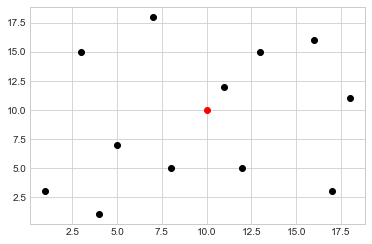

In [39]:
from __future__ import print_function
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')
import numpy as np


data_points = [(10,10), 
               (5,7),
               (11,12),
               (17,3),
               (4,1),
               (1,3),
               (3,15),
               (18,11),
               (13,15),
               (12,5),
               (7,18),
               (16,16),
               (8,5)]


def distance_matrix():
    matrix = [[None for i in range(13)] for j in range(13)];
    for x in range(len(data_points)) :
        for y in range(len(data_points)):
            manhattan_distance = abs(data_points[x][0] - data_points[y][0]) + abs(data_points[x][1] - data_points[y][1]);
            matrix[x][y] = manhattan_distance;
            matrix[y][x] = manhattan_distance;
    return matrix;
            

def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data['distance_matrix'] = distance_matrix();
    data['num_vehicles'] = 2
    data['depot'] = 0
    return data


def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    max_route_distance = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        while not routing.IsEnd(index):
            plan_output += ' {} -> '.format(manager.IndexToNode(index))
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        plan_output += '{}\n'.format(manager.IndexToNode(index))
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        print(plan_output)
        max_route_distance = max(route_distance, max_route_distance)
    print('Maximum of the route distances: {}m'.format(max_route_distance))




def main():
    i = 0;
    for (x, y) in data_points:
        if i == 0:
            color = 'red'
        else:
            color = 'black'
        i += 1;
        plt.plot(x, y, 'o', color=color);
    
    """Solve the CVRP problem."""
    # Instantiate the data problem.
    data = create_data_model()

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'], data['depot'])

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)


    # Create and register a transit callback.
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Distance constraint.
    dimension_name = 'Distance'
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        2000,  # vehicle maximum travel distance
        True,  # start cumul to zero
        dimension_name)
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if solution:
        print_solution(data, manager, routing, solution)


if __name__ == '__main__':
    main()

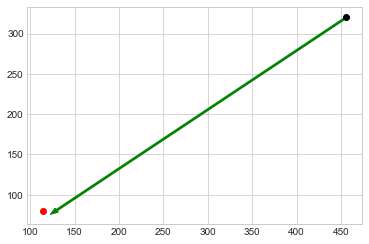

In [13]:
plt.plot(456, 320, 'o', color='black');
plt.plot(114, 80, 'o', color='red');
plt.arrow(456, 320, 114-440, 80-319, color='green', shape='full', width=2.0);